We hypothesise that there will be two significant peaks in the greyscale intesity of the CT scans, due to edge effects: these will be at the boundary between air and the cementum, and at the cementum-dentine boundary.

To check this we will find 4 random images from 4 teeth, straighten them and plot the greyscale intensity along each row. Hopefully we will see these two peaks.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
"""
Choose an image to demonstrate with

"""
import os
import numpy as np


def paths(i: int):
    """Image and Mask path from an index"""
    rvs = f"data/original cut/{i:04d}.tif", f"data/masks cut/{i:04d}.tif"
    for path in rvs:
        assert os.path.exists(path), path

    return rvs


rng = np.random.default_rng()
index = rng.integers(0, 516)
index = 141
img_path, mask_path = paths(index)

img_path, mask_path

('data/original cut/0141.tif', 'data/masks cut/0141.tif')

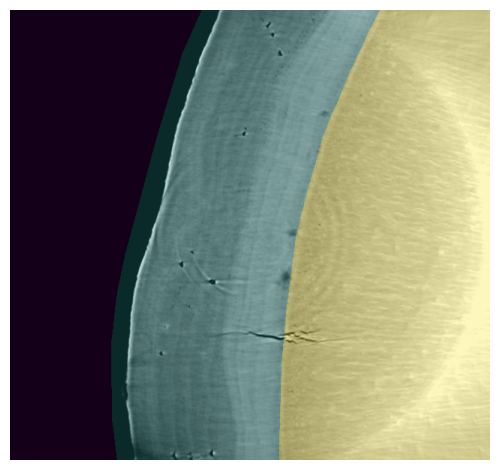

In [9]:
"""
Display it

"""
import matplotlib.pyplot as plt

fig, axis = plt.subplots()

img = plt.imread(img_path)
mask = plt.imread(mask_path)

axis.imshow(img, cmap="gray")
axis.imshow(mask, alpha=0.3)

axis.set_axis_off()

imgdir = f"img/detect_cementum/{index}/"
if not os.path.isdir(imgdir):
    os.makedirs(imgdir)

fig.tight_layout()
fig.savefig(f"{imgdir}/img_masks.png", bbox_inches="tight")

/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 45 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 9 zero rows from bottom
  warnings.warn(


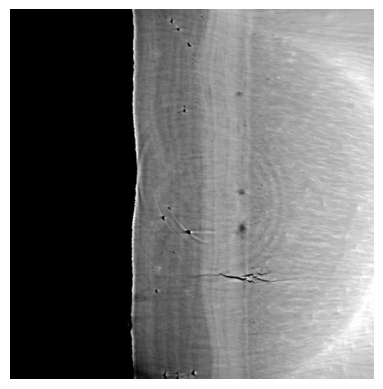

In [10]:
"""
Straighten these images according the the masks

"""
from cementum import straighten

n_y = 20
n_left, n_x, n_right = 5, 5, 5

fig, axis = plt.subplots()

# Define two grids of points that will we use to perform our straightening
curve_pts = straighten.mask_mesh(mask, n_y, (n_left, n_x, n_right))
straight_pts = straighten.straight_mesh(mask, n_y, (n_left, n_x, n_right))

# Straighten the image
img = plt.imread(img_path)
straight_image = straighten.apply_transformation(img, curve_pts, straight_pts)

# Straighten the mask
straight_mask = straighten.apply_transformation(mask, curve_pts, straight_pts)

# Remove the white columns from the image and the corresponding columns from the mask
straight_image, straight_mask = straighten.remove_white_cols(
    straight_image, straight_mask
)

# Remove padding
straight_image = straighten.remove_padding(straight_image)
straight_mask = straighten.remove_padding(straight_mask)


# Display it
axis.imshow(straight_image, cmap="gray")
axis.set_axis_off()

fig.savefig(f"{imgdir}/straightened.png", bbox_inches="tight")

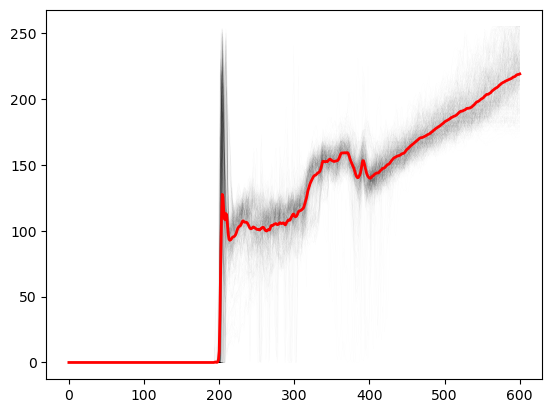

In [11]:
"""
Plot the greyscale intensity across each row for all of these images

"""
fig, axis = plt.subplots()

intensity_profile = np.mean(straight_image, axis=0)

for row in straight_image:
    axis.plot(row, alpha=0.05, linewidth=0.05, color="k")
axis.plot(intensity_profile, color="r", linewidth=2)

fig.savefig(f"{imgdir}/intensity.png", bbox_inches="tight")

 56%|█████▋    | 105/186 [00:21<00:16,  4.88it/s]


saving img/detect_cementum/141//anim/animation.mp4


/home/mh19137/cementum/cementum/fit_cementum.py:271: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(util.coloured(e, util.bcolours.WARNING))
/home/mh19137/miniforge3/envs/tf2/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/mh19137/miniforge3/envs/tf2/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


58 [ 15.78761382  11.48113216  13.74241525  17.11661979  14.66314707
  11.41056042  29.03546272 596.51919322 106.37412115 201.62530621
 190.48780112]
65 [ 15.78761382  11.48113216  13.74241525  17.11661979  14.66314707
  11.41056042  29.03546272 596.51919322 106.37412115 201.62530621
 190.48780112]
72 [ 15.78761382  11.48113216  13.74241525  17.11661979  14.66314707
  11.41056042  29.03546272 596.51919322 106.37412115 201.62530621
 190.48780112]
84 [ 15.78761382  11.48113216  13.74241525  17.11661979  14.66314707
  11.41056042  29.03546272 596.51919322 106.37412115 201.62530621
 190.48780112]
95 [ 15.78761382  11.48113216  13.74241525  17.11661979  14.66314707
  11.41056042  29.03546272 596.51919322 106.37412115 201.62530621
 190.48780112]
117 [ 15.78761382  11.48113216  13.74241525  17.11661979  14.66314707
  11.41056042  29.03546272 596.51919322 106.37412115 201.62530621
 190.48780112]
120 [ 15.78761382  11.48113216  13.74241525  17.11661979  14.66314707
  11.41056042  29.03546272 59

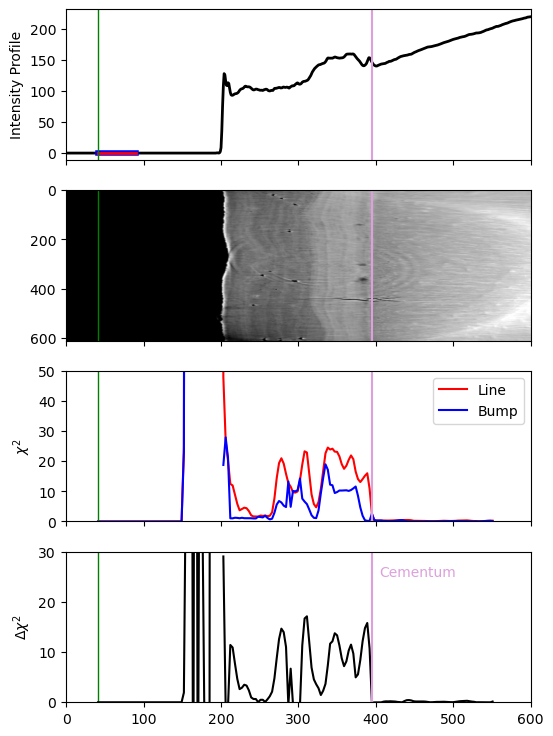

In [12]:
"""
Gif showing the fit process

"""
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

from cementum import fit_cementum

# Fit params
domain_length = 50

# Peak detection params
tolerance = 7
rel_height = 0.99

fig, axes = plt.subplots(4, 1, figsize=(6, 9), sharex=True)

# Show the intensity profile and image
axes[0].plot(
    np.arange(straight_image.shape[1]), intensity_profile, color="k", linewidth=2
)
axes[1].imshow(straight_image, cmap="gray", aspect="auto")

axes[2].set_ylim((0, 50))
axes[3].set_ylim((0, 30))

offsets = np.arange(0, straight_image.shape[0] - 2 * domain_length, 3)

# Do one fit
line_params, line_chi2, line_x = fit_cementum.fit_line_restricted_domain(
    offsets[0], intensity_profile, n_pixels=domain_length
)
bump_params, bump_chi2, bump_x = fit_cementum.fit_line_with_bump_restricted_domain(
    offsets[0], intensity_profile, n_pixels=domain_length
)

assert (bump_x == line_x).all()
leftmost_points = [line_x.min()]

line_chi2s = [line_chi2]
bump_chi2s = [bump_chi2]

# Show the fits
(bump_line,) = axes[0].plot(
    bump_x,
    fit_cementum.line_with_bump(bump_x, *bump_params),
    "b",
    linewidth=4,
)
(fit_line,) = axes[0].plot(
    line_x,
    fit_cementum._line(line_x, *line_params),
    "r",
    linewidth=2,
)

# goodness of fits
(line_chi2_line,) = axes[2].plot(leftmost_points, line_chi2s, "-r", label="Line")
(bump_chi2_line,) = axes[2].plot(leftmost_points, bump_chi2s, "-b", label="Bump")

# Vertical lines tracking where we are
vlines = [axis.axvline(leftmost_points[-1], color="g", linewidth=1) for axis in axes]

# Delta Chi2
delta_chi2 = [line_chi2 - bump_chi2]
(delta_chi2_line,) = axes[3].plot(leftmost_points, delta_chi2, "-k", label="Delta Chi2")

# Progress bar
pbar = tqdm(total=len(offsets))


# Animation
def update_lines(offset):
    """
    Perform another fit and update the lines

    """
    global pbar

    # Re do fits
    line_params, line_chi2, line_x = fit_cementum.fit_line_restricted_domain(
        offset, intensity_profile, n_pixels=domain_length
    )
    (
        bump_params,
        bump_chi2,
        bump_x,
    ) = fit_cementum.fit_line_with_bump_restricted_domain(
        offset, intensity_profile, n_pixels=domain_length
    )

    # Update fit lines
    assert (line_x == bump_x).all()
    leftmost_points.append(line_x.min())
    fit_line.set_data(line_x, fit_cementum._line(line_x, *line_params))
    bump_line.set_data(bump_x, fit_cementum.line_with_bump(bump_x, *bump_params))

    # Update chi2 lines
    line_chi2s.append(line_chi2)
    bump_chi2s.append(bump_chi2)
    line_chi2_line.set_data(leftmost_points, line_chi2s)
    bump_chi2_line.set_data(leftmost_points, bump_chi2s)

    delta_chi2.append(line_chi2 - bump_chi2)
    delta_chi2_line.set_data(leftmost_points, delta_chi2)

    # Update vertical lines
    for line in vlines:
        line.set_data([leftmost_points[-1], leftmost_points[-1]], line.get_ydata())

    pbar.update(1)

    return fit_line, bump_line, line_chi2_line, bump_chi2_line, delta_chi2_line, *vlines


anim = FuncAnimation(
    fig,
    update_lines,
    frames=offsets,
    fargs=(),
    interval=30,
    blit=True,
)

axes[0].set_ylabel("Intensity Profile")
axes[2].legend()
axes[2].set_ylabel(r"$\chi^2$")
axes[3].set_ylabel(r"$\Delta\chi^2$")

anim_dir = f"{imgdir}/anim"
if not os.path.isdir(anim_dir):
    os.mkdir(anim_dir)

path = f"{anim_dir}/animation.mp4"
print(f"saving {path}")
anim.save(path)

# Detect the cementum peak, plot + save it
peak_location = fit_cementum.find_cementum(
    leftmost_points, delta_chi2, tolerance=tolerance, rel_height=1.0
)
for axis in axes:
    axis.axvline(peak_location, color="plum")

axes[3].text(peak_location + 10, 25, "Cementum", color="plum")
path = f"{imgdir}detection.png"
print(path)
fig.savefig(path, bbox_inches="tight")

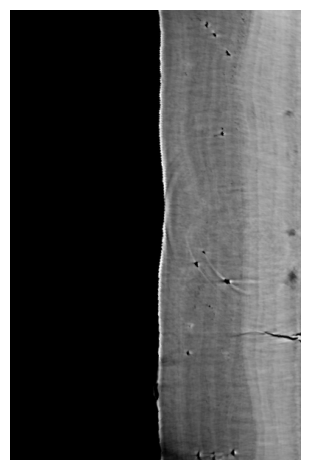

In [13]:
"""
Crop the cementum out

"""
cropped_img = straight_image[:, :peak_location]

fig, axis = plt.subplots()
axis.imshow(cropped_img, cmap="gray")
axis.set_axis_off()

fig.tight_layout()
fig.savefig(f"{imgdir}/cropped.png", bbox_inches="tight")

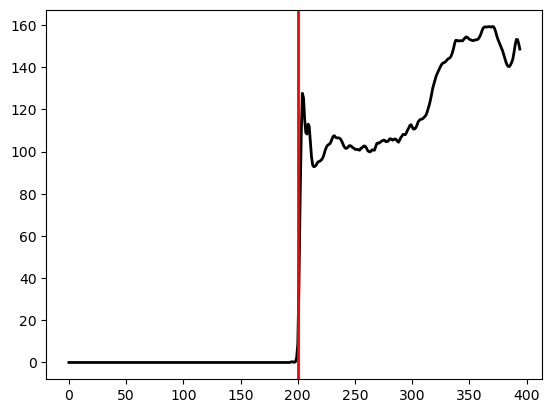

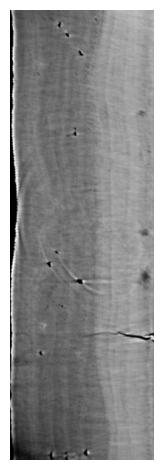

In [19]:
"""
Find the left edge of the cementum...

"""
import ruptures as rpt

mean = np.mean(cropped_img, axis=0)

edge, *_ = rpt.Binseg(model="l1").fit(mean).predict(pen=10)

fig, axis = plt.subplots()

axis.plot(mean, color="k", linewidth=2)
axis.axvline(edge, color="r", linewidth=2)

fig, axis = plt.subplots()
cropped_img = cropped_img[:, edge:]
axis.imshow(cropped_img, cmap="gray")
axis.set_axis_off()
fig.tight_layout()
fig.savefig(f"{imgdir}/double_cropped.png", bbox_inches="tight")

np.save("cropped_image.npy", cropped_img)